In [10]:
# data modules
import pandas as pd
import numpy as np

# plotting modules
from matplotlib.pyplot import figure
import matplotlib.pyplot as plot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib import colorbar, colors
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

# data aggregation module for meteostat data
from meteostat import Point,Stations, Daily, Hourly, Monthly

# other modules
import datetime
from datetime import datetime


### Data Aggregation and Cleaning ###

In [2]:
# Aggregate ENSO data from CPC

# read in ENSO data from CPC uisng pd.read_csv
enso = pd.read_csv('https://www.cpc.ncep.noaa.gov/data/indices/wksst9120.for',
                   header=None,skiprows=4, engine='python')
enso_df = pd.DataFrame(enso)

# break dataframe into proper columns based on ENSO region values
enso_df[["Date", "Nino1+2", "Nino3", "Nino34", "Nino4"]]=enso_df[0].str.split("     ", expand = True)

del enso_df[enso_df.columns[0]] # delete date column

# create custom date range so datetime object can be created
enso_df["Date"]=pd.date_range(start='9/2/1981', end='2/22/2023', freq='w-wed')

# set index as "Date" column
enso_df.set_index("Date", inplace = True)

# Break ENSO numerical values into subset of observed SSTs and SSTAs (place comma (',') between respective values)
for r in range(0,len(enso_df["Nino1+2"])):
    enso_df["Nino1+2"][r]= ', '.join(enso_df["Nino1+2"][r][i:i + 4] for i in range(0, len(enso_df["Nino1+2"][r]), 4))

for r in range(0,len(enso_df["Nino3"])):
    enso_df["Nino3"][r]= ', '.join(enso_df["Nino3"][r][i:i + 4] for i in range(0, len(enso_df["Nino3"][r]), 4))

for r in range(0,len(enso_df["Nino34"])):
    enso_df["Nino34"][r]= ', '.join(enso_df["Nino34"][r][i:i + 4] for i in range(0, len(enso_df["Nino34"][r]), 4))

for r in range(0,len(enso_df["Nino4"])):
    enso_df["Nino4"][r]= ', '.join(enso_df["Nino4"][r][i:i + 4] for i in range(0, len(enso_df["Nino4"][r]), 4))

# Assign SST and SSTA columns for each ENSO index
enso_df[['Nino1+2:SST', 'Nino1+2:SSTA']] =enso_df["Nino1+2"].str.split(",", expand = True)
enso_df[['Nino3:SST', 'Nino3:SSTA']] =enso_df["Nino3"].str.split(",", expand = True)
enso_df[['Nino34:SST', 'Nino34:SSTA']] =enso_df["Nino34"].str.split(",", expand = True)
enso_df[['Nino4:SST', 'Nino4:SSTA']] =enso_df["Nino4"].str.split(",", expand = True)

# Convert string values to float values
enso_df['Nino1+2:SST'] = enso_df['Nino1+2:SST'].apply(lambda x: float(x))
enso_df['Nino1+2:SSTA'] = enso_df['Nino1+2:SSTA'].apply(lambda x: float(x))

enso_df['Nino3:SST'] = enso_df['Nino3:SST'].apply(lambda x: float(x))
enso_df['Nino3:SSTA'] = enso_df['Nino3:SSTA'].apply(lambda x: float(x))

enso_df['Nino34:SST'] = enso_df['Nino34:SST'].apply(lambda x: float(x))
enso_df['Nino34:SSTA'] = enso_df['Nino34:SSTA'].apply(lambda x: float(x))

enso_df['Nino4:SST'] = enso_df['Nino4:SST'].apply(lambda x: float(x))
enso_df['Nino4:SSTA'] = enso_df['Nino4:SSTA'].apply(lambda x: float(x))

# delete unneeded columns
enso_df.drop(['Nino1+2','Nino3', 'Nino34', 'Nino4','Nino1+2:SST','Nino3:SST', 'Nino34:SST', 'Nino4:SST'], axis =1, inplace = True)

print(enso_df.head(10), enso_df.tail(10)) # print dataframe


            Nino1+2:SSTA  Nino3:SSTA  Nino34:SSTA  Nino4:SSTA
Date                                                         
1981-09-02          -0.1        -0.1         -0.2        -0.3
1981-09-09          -0.6        -0.2         -0.2        -0.2
1981-09-16          -0.9        -0.3         -0.2        -0.3
1981-09-23          -0.4        -0.6         -0.5        -0.5
1981-09-30          -0.8        -0.3         -0.4        -0.6
1981-10-07          -0.7        -0.2         -0.2        -0.3
1981-10-14          -0.9        -0.1         -0.3        -0.3
1981-10-21          -0.7        -0.2         -0.0        -0.0
1981-10-28          -0.5        -0.4         -0.5        -0.4
1981-11-04          -0.6        -0.7         -1.0        -0.6             Nino1+2:SSTA  Nino3:SSTA  Nino34:SSTA  Nino4:SSTA
Date                                                         
2022-12-21          -0.1        -0.6         -0.8        -0.8
2022-12-28          -0.3        -0.5         -0.7        -0.8
2023-01-

### Data Visualizations: Time Series Analysis ###

ENSO Region is: Nino34
Temporal Filter is: 26 weeks


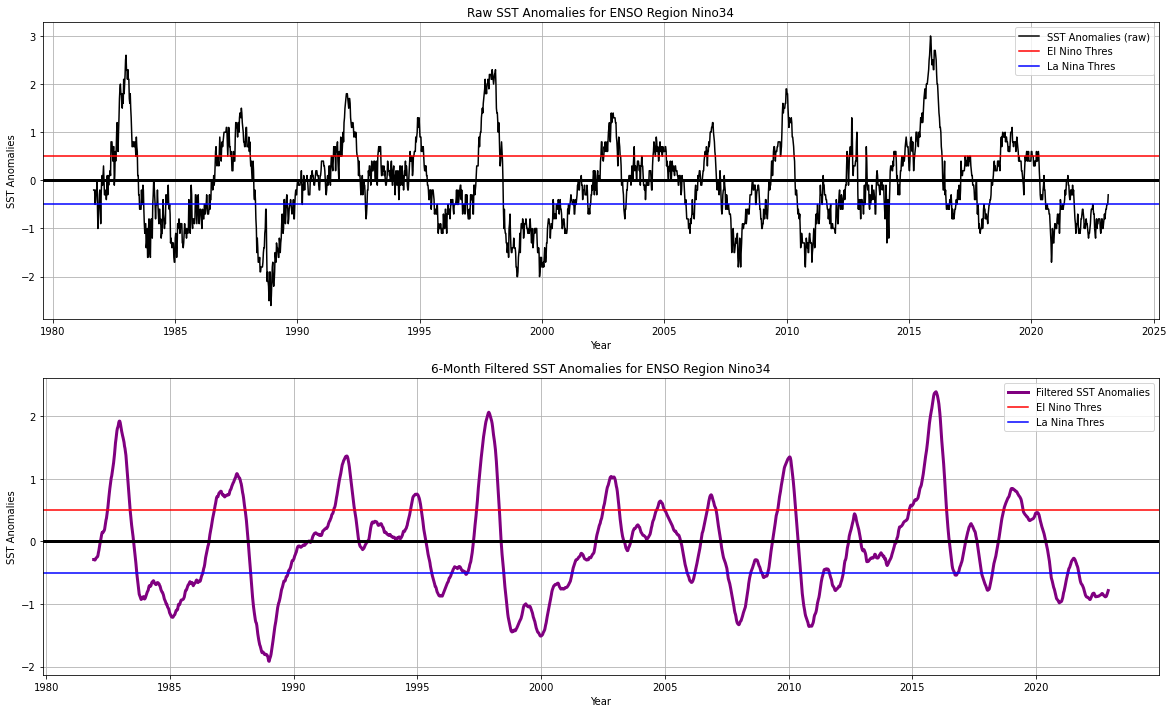

In [3]:
# ENSO Time Series - Full Period

# This plot allows the user to focus on a specific ENSO index for the entire ENSO record (1981 - present). It also allows the user
# to filter and smooth these values monthly, seasonally or annually

# User input for ENSO Region
user_input_enso_var = input("Enter ENSO Region (Nino1+2, Nino3, Nino34, Nino4)")
print("ENSO Region is: " + user_input_enso_var)

# User input for filter
filter_coef = input("Enter temporal filter to identify ENSO Events (4 = 1-month running mean, 13 = 3-month running mean), 26 = 6-monthrunning mean )")
print("Temporal Filter is: " + filter_coef + " weeks")
filter_coef = int(filter_coef)

if filter_coef == 4:
    plot_title = "Monthly"
if filter_coef == 13:
    plot_title = "3-Month: Seasonal"
if filter_coef == 26:
    plot_title = "6-Month"

# Smoothing filter using rolling mean for desired temporal frequency
rolling_mean_sst = enso_df["{}".format(user_input_enso_var)+":SSTA"].rolling(window=filter_coef, center=True).mean()



# Plotting ENSO time series

# Plot 1 [0] is using the raw SSTA data for the ENSO region
fig,ax = plt.subplots(2,figsize = (20,12))
ax[0].plot(enso_df.index,enso_df["{}".format(user_input_enso_var)+":SSTA"], color = 'black')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('SST Anomalies')
ax[0].set_title('Raw SST Anomalies for ENSO Region {}'.format(user_input_enso_var))
ax[0].grid()
ax[0].axhline(y = 0.5, color = 'r', linestyle = '-')
ax[0].axhline(y = -0.5, color = 'b', linestyle = '-')
ax[0].axhline(y = 0, color = 'k', linestyle = '-', linewidth=3.0)
ax[0].legend(["SST Anomalies (raw)", "El Nino Thres", "La Nina Thres"])

# Plot 2 [1] is using the filtered SSTA data for the ENSO region
ax[1].plot(enso_df.index,rolling_mean_sst, color='purple', linewidth=3) 
ax[1].set_xlabel('Year')
ax[1].set_ylabel('SST Anomalies')
ax[1].set_title('{} Filtered SST Anomalies for ENSO Region {}'.format(plot_title,user_input_enso_var))
ax[1].grid()
plt.axhline(y = 0.5, color = 'r', linestyle = '-')
plt.axhline(y = -0.5, color = 'b', linestyle = '-')
plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth=3.0)
ax[1].legend(["Filtered SST Anomalies", "El Nino Thres", "La Nina Thres"])


ENSO Region is: Nino34
Starting period is: month= 01 year= 2015
Ending period is: month= 12 year= 2016


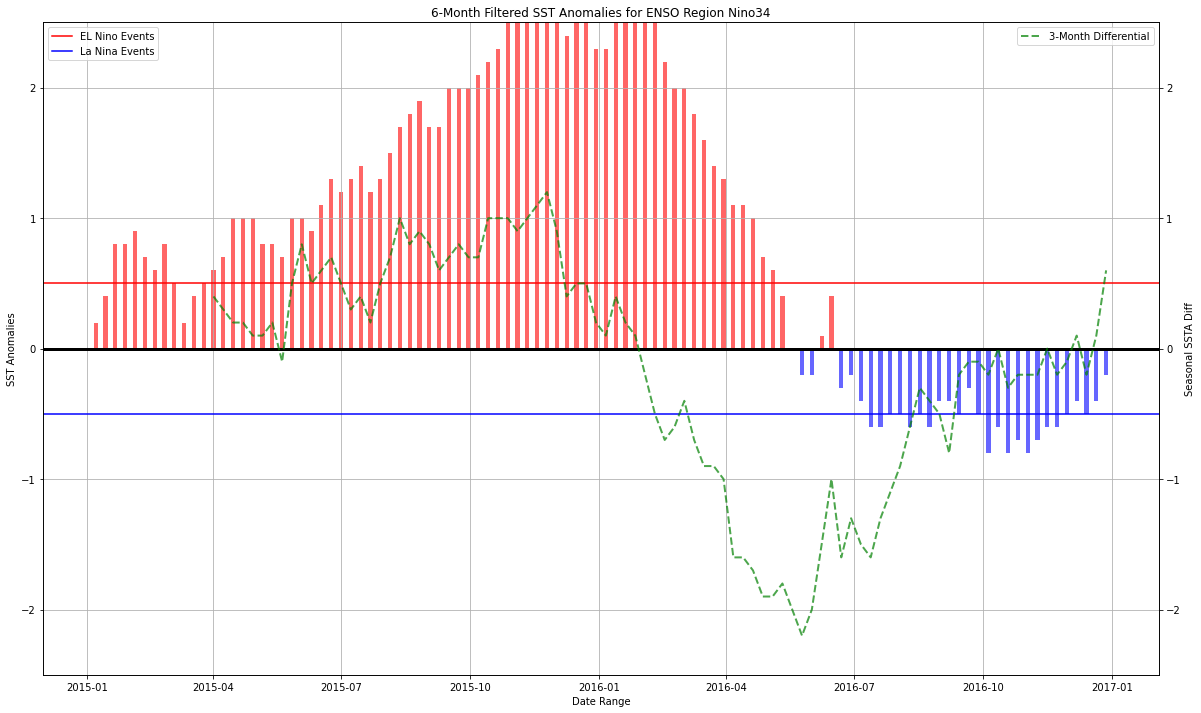

In [4]:
# ENSO Time Series - For Select Period and Seasonality Trends

# This visual provides the ENSO index for the selected region as a vertical +/- bar graph. It also plots the seasonal (3-month) 
# ENSO index difference to better understand ENSO trends and help highlight periods of significant change.

# User input for ENSO Region
ENSO_input = input("Enter ENSO Region (Nino1+2, Nino3, Nino34, Nino4)")
print("ENSO Region is: " + user_input_enso_var)


# User input for start/end dates for period of interest
start_year = input("Enter starting year of period:")
start_month = input("Enter starting month of period (need two digits for month):")
print("Starting period is: month= " + start_month + " year= " + start_year)

end_year = input("Enter ending year of period:")
end_month = input("Enter ending month of period (need two digits for month):")
print("Ending period is: month= " + end_month + " year= " + end_year)

# Isolate period based on input
bar_df = enso_df["{}:SSTA".format(ENSO_input)].loc["{}""-""{}".format(start_year, start_month):"{}""-""{}".format(end_year, end_month)] 

# Identify bar colors based on ENSO index
colors = ['r' if x > 0 else 'b' for x in bar_df]

# Calculate time derivative with respect to ENSO index seasonally (12 weeks) 
ENSO_per_diff = bar_df.diff(periods=12)

# Create figure with primary axis
fig, ax1 = plt.subplots(figsize = (20,12))

# Plot bar chart of SSTA on axis 1
ax1.bar(bar_df.index, bar_df, color=colors, width = 3, alpha = 0.6)
ax1.grid() # create grid
ax1.set_ylabel('SST Anomalies') # y-axis label
ax1.set_xlabel('Date Range')# x-axis label
ax1.set_ylim(-2.5, 2.5) # set y-axis range

plt.axhline(y = 0.5, color = 'r', linestyle = '-') # horizonal line for El Nino
plt.axhline(y = -0.5, color = 'b', linestyle = '-') # horizonal line for La Nina
plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth=3.0) # 0-line
plt.title('Analysis for ENSO region {} between periods {}-{} and {}-{} with seasonal SSTA differences'.format(ENSO_input, bar_df.index[0].month,bar_df.index[0].year, bar_df.index[-1].month,bar_df.index[-1].year))

ax1.legend(["EL Nino Events", "La Nina Events"], loc="upper left")
ax1.set_title('{} Filtered SST Anomalies for ENSO Region {}'.format(plot_title,user_input_enso_var))

# set up secondary axis for plot 2
ax2 = ax1.twinx()

# line plot for seaonal SST difference 
ax2.plot(ENSO_per_diff.index, ENSO_per_diff, color = 'green', alpha = 0.7, linestyle='dashed', linewidth = 2.0 ) 
ax2.set_ylabel('Seasonal SSTA Diff') # set y-label
ax2.set_ylim(-2.5, 2.5)# set y-range
ax2.legend(['3-Month Differential'], loc="upper right")

plt.show()

### Data Visualizations - Mapping ###

In [5]:
# This function is used to identify the color associated with the input ENSO index. Cooler colors indicate La Nina phases
# while warmer colors indicate EL Nino phases

def enso_color_code(input_SSA):
    global fill_color
    global op_alpha
    if (input_SSA < 0.5) & (input_SSA > 0):
        fill_color = "red"
        op_alpha = 0.2
    elif (input_SSA >= 0.5) & (input_SSA < 1):
        fill_color = "red"
        op_alpha = 0.4
    elif (input_SSA >= 1) & (input_SSA < 2):
        fill_color = "red"
        op_alpha = 0.6
    elif (input_SSA >= 2):
        fill_color = "red"
        op_alpha = 0.8
    elif (input_SSA < 0) & (input_SSA > -0.5):
        fill_color = "blue"
        op_alpha = 0.2
    elif (input_SSA <= -0.5) & (input_SSA > -1):
        fill_color = "darkblue"
        op_alpha = 0.4
    elif (input_SSA <= -1) & (input_SSA > -2):
        fill_color = "darkblue"
        op_alpha = 0.6
    elif (input_SSA <= -2):
        fill_color = "darkblue"
        op_alpha = 0.8
        
    return fill_color, op_alpha # return fill color and transparency

Temporal Filter is: seasonal
Seaonally filtered forsummer
SSTA calculations based on input 0.33 -0.36 -0.35 0.15


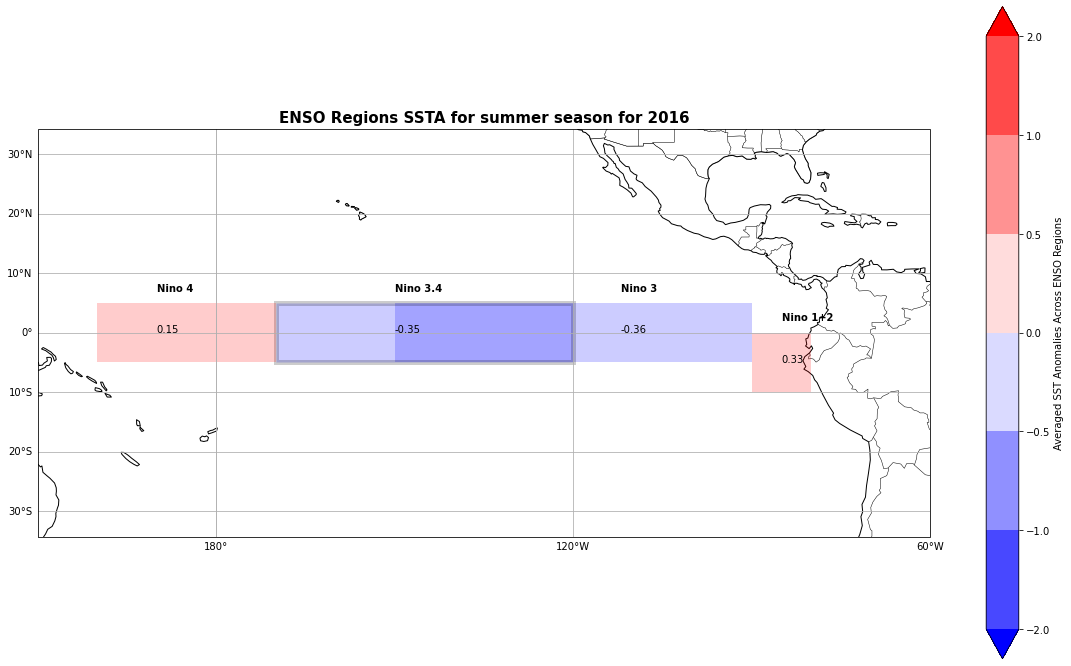

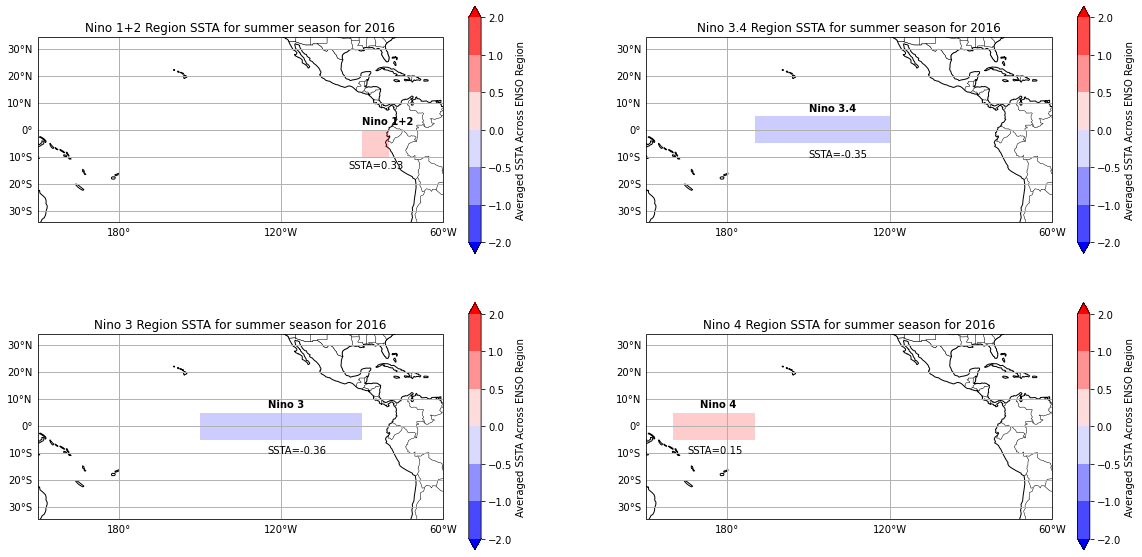

In [6]:
# Mapping Visuals - All ENSO Regions

# The following will plot the monthly/seasonally/annaully averaged SSTs across all ENSO regions
# This will include color-coded indicators for ENSO conditions as well as numerical represenations

# User input for filter
filter_title = input("Enter temporal filter (monthly, seasonal, annual)")
print("Temporal Filter is: " + filter_title )

# User input for start/end dates for period of interest
filter_year = input("Enter year of interest:")

# Calculate averages depending on user input

# Monthly averaged SSTA calculations
if filter_title == "monthly":
    filter_month = input("Enter month of interest (need two digits for month):")
    ENSO_filter_Nino12 = round(enso_df["Nino1+2:SSTA"].loc["{}""-""{}".format(filter_year, filter_month)].mean(),2)    #enso_df["Date"] == datetime.da]
    ENSO_filter_Nino3 = round(enso_df["Nino3:SSTA"].loc["{}""-""{}".format(filter_year, filter_month)].mean(),2) 
    ENSO_filter_Nino34 = round(enso_df["Nino34:SSTA"].loc["{}""-""{}".format(filter_year, filter_month)].mean(),2) 
    ENSO_filter_Nino4 = round(enso_df["Nino4:SSTA"].loc["{}""-""{}".format(filter_year, filter_month)].mean(),2) 

# Annually averaged SSTA calculations   
elif filter_title == "annual":
    ENSO_filter_Nino12 = round(enso_df["Nino1+2:SSTA"].loc["{}".format(filter_year)].mean(),2)    #enso_df["Date"] == datetime.da]
    ENSO_filter_Nino3 = round(enso_df["Nino3:SSTA"].loc["{}".format(filter_year)].mean(),2) 
    ENSO_filter_Nino34 = round(enso_df["Nino34:SSTA"].loc["{}".format(filter_year)].mean(),2) 
    ENSO_filter_Nino4 = round(enso_df["Nino4:SSTA"].loc["{}".format(filter_year)].mean(),2) 

# Seasonally averaged SSTA calcualtions
elif filter_title == "seasonal":
    filter_season = input("Input season of interest:")
    print("Seaonally filtered for" + filter_season)
    if filter_season =="winter":
        ENSO_filter_Nino12 = round(enso_df["Nino1+2:SSTA"].loc["{}""-01".format(filter_year):"{}""-02".format(filter_year)].mean(),2)    #enso_df["Date"] == datetime.da]
        ENSO_filter_Nino3 = round(enso_df["Nino3:SSTA"].loc["{}""-01".format(filter_year):"{}""-02".format(filter_year)].mean(),2) 
        ENSO_filter_Nino34 = round(enso_df["Nino34:SSTA"].loc["{}""-01".format(filter_year):"{}""-02".format(filter_year)].mean(),2) 
        ENSO_filter_Nino4 = round(enso_df["Nino4:SSTA"].loc["{}""-01".format(filter_year):"{}""-02".format(filter_year)].mean(),2) 

    if filter_season =="spring":
        ENSO_filter_Nino12 = round(enso_df["Nino1+2:SSTA"].loc["{}""-03".format(filter_year):"{}""-05".format(filter_year)].mean(),2)    #enso_df["Date"] == datetime.da]
        ENSO_filter_Nino3 = round(enso_df["Nino3:SSTA"].loc["{}""-03".format(filter_year):"{}""-05".format(filter_year)].mean(),2) 
        ENSO_filter_Nino34 = round(enso_df["Nino34:SSTA"].loc["{}""-03".format(filter_year):"{}""-05".format(filter_year)].mean(),2) 
        ENSO_filter_Nino4 = round(enso_df["Nino4:SSTA"].loc["{}""-03".format(filter_year):"{}""-05".format(filter_year)].mean(),2) 

    if filter_season =="summer":
        ENSO_filter_Nino12 = round(enso_df["Nino1+2:SSTA"].loc["{}""-06".format(filter_year):"{}""-08".format(filter_year)].mean(),2)    #enso_df["Date"] == datetime.da]
        ENSO_filter_Nino3 = round(enso_df["Nino3:SSTA"].loc["{}""-06".format(filter_year):"{}""-08".format(filter_year)].mean(),2) 
        ENSO_filter_Nino34 = round(enso_df["Nino34:SSTA"].loc["{}""-06".format(filter_year):"{}""-08".format(filter_year)].mean(),2) 
        ENSO_filter_Nino4 = round(enso_df["Nino4:SSTA"].loc["{}""-06".format(filter_year):"{}""-08".format(filter_year)].mean(),2) 

    if filter_season =="fall":
        ENSO_filter_Nino12 = round(enso_df["Nino1+2:SSTA"].loc["{}""-09".format(filter_year):"{}""-11".format(filter_year)].mean(),2)    #enso_df["Date"] == datetime.da]
        ENSO_filter_Nino3 = round(enso_df["Nino3:SSTA"].loc["{}""-09".format(filter_year):"{}""-11".format(filter_year)].mean(),2) 
        ENSO_filter_Nino34 = round(enso_df["Nino34:SSTA"].loc["{}""-09".format(filter_year):"{}""-11".format(filter_year)].mean(),2) 
        ENSO_filter_Nino4 = round(enso_df["Nino4:SSTA"].loc["{}""-09".format(filter_year):"{}""-11".format(filter_year)].mean(),2) 

print("SSTA calculations based on input", ENSO_filter_Nino12,ENSO_filter_Nino3, ENSO_filter_Nino34, ENSO_filter_Nino4) 


# Identify figure and projections
fig = plt.figure(figsize=(20, 12))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-75))

# Specify geographical features
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='black')
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Color-coded ENSO regions based on averaged SSTAs
ax.add_patch(mpatches.Rectangle(xy=[-90, -10], width=10, height=10,
                                    facecolor='{}'.format(enso_color_code(ENSO_filter_Nino12)[0]),
                                    alpha=float('{}'.format(enso_color_code(ENSO_filter_Nino12)[1])),
                                    transform=ccrs.PlateCarree())
)
ax.add_patch(mpatches.Rectangle(xy=[-150, -5], width=60, height=10,
                                    facecolor='{}'.format(enso_color_code(ENSO_filter_Nino3)[0]),
                                    alpha=float('{}'.format(enso_color_code(ENSO_filter_Nino3)[1])),
                                    transform=ccrs.PlateCarree())
)
ax.add_patch(mpatches.Rectangle(xy=[-170, -5], width=50, height=10,lw=5, ec='k',
                                    facecolor='{}'.format(enso_color_code(ENSO_filter_Nino34)[0]),
                                    alpha=float('{}'.format(enso_color_code(ENSO_filter_Nino34)[1])),
                                    transform=ccrs.PlateCarree())
)
ax.add_patch(mpatches.Rectangle(xy=[-200, -5], width=30, height=10,
                                    facecolor='{}'.format(enso_color_code(ENSO_filter_Nino4)[0]),
                                    alpha=float('{}'.format(enso_color_code(ENSO_filter_Nino4)[1])),
                                    transform=ccrs.PlateCarree())
)

# Text added to plot for reference
ax.text(-85, 2, 'Nino 1+2',weight='bold', transform=ccrs.PlateCarree())
ax.text(-112, 7, 'Nino 3',weight='bold', transform=ccrs.PlateCarree())
ax.text(-150, 7, 'Nino 3.4',weight='bold', transform=ccrs.PlateCarree())
ax.text(-190, 7, 'Nino 4',weight='bold', transform=ccrs.PlateCarree())
ax.text(-85, -5,"{}".format(ENSO_filter_Nino12), transform=ccrs.PlateCarree())
ax.text(-112, -0,"{}".format(ENSO_filter_Nino3), transform=ccrs.PlateCarree())
ax.text(-150, -0,"{}".format(ENSO_filter_Nino34), transform=ccrs.PlateCarree())
ax.text(-190, -0,"{}".format(ENSO_filter_Nino4), transform=ccrs.PlateCarree())

# Map title
if filter_title == "seasonal":
            ax.set_title('ENSO Regions SSTA for {} season for {}'.format(filter_season, filter_year), fontsize=15, weight='bold')
elif filter_title == "monthly":
            ax.set_title('ENSO Regions SSTA for month {} of year {}'.format(filter_month, filter_year), fontsize=15, weight='bold')
elif filter_title == "annual":
            ax.set_title('ENSO Regions SSTA for the year of {}'.format(filter_year), fontsize=15, weight='bold')


# Set map extent
ax.set_extent((150, 300, -10, 10))

# Colorbar parameters
cmap = mpl.cm.bwr
bounds = [-2, -1, -0.5, 0, 0.5, 1, 2]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both') 
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             orientation='vertical')
cbar.set_label("Averaged SST Anomalies Across ENSO Regions")


plt.show() # show plot


#_____________________________________________________________________________________________________________________


# Mapping Visuals - Individual ENSO Regions

# The following will plot the monthly/seasonally/annaully averaged SSTs across each ENSO region separately.
# This will include color-coded indicators for ENSO conditions as well as numerical represenations.

vars_plot=list(["Nino1+2:SSTA", "Nino3:SSTA", "Nino34:SSTA", "Nino4:SSTA"])

# create 2x2 panel for maps
nrows=2
ncols=2

# set map projections
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-75)},
                        figsize=(20,10))
ax = ax.flatten()

# loop through each ENSO region to plot individual regions
for i,mode in enumerate(vars_plot):

    ax[i].add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
    ax[i].add_feature(cfeature.STATES, linewidth=0.3, edgecolor='black')
    ax[i].coastlines()
    ax[i].gridlines()
    ax[i].set_extent((150, 300, -10, 10))
    
    gl = ax[i].gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False

    cmap = mpl.cm.bwr
    bounds = [-2, -1, -0.5, 0, 0.5, 1, 2]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both') 
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax[i], orientation='vertical')

    if i == 0:
        color_code = enso_color_code(ENSO_filter_Nino12)
        ax[i].add_patch(mpatches.Rectangle(xy=[-90, -10], width=10, height=10,
                                    facecolor= color_code[0],
                                    alpha= color_code[1],
                                    transform=ccrs.PlateCarree())
                        )
        ax[i].text(-90, 2, 'Nino 1+2',weight='bold', transform=ccrs.PlateCarree())
        ax[i].text(-95, -14,"SSTA={}".format(ENSO_filter_Nino12), transform=ccrs.PlateCarree())
        cbar.set_label("Averaged SSTA Across ENSO Region")

        if filter_title == "seasonal":
            ax[i].set_title('Nino 1+2 Region SSTA for {} season for {}'.format(filter_season, filter_year), fontsize=12)
        elif filter_title == "monthly":
            ax[i].set_title('Nino 1+2 Region SSTA for month {} of year {}'.format(filter_month, filter_year), fontsize=12)
        elif filter_title == "annual":
            ax[i].set_title('Nino 1+2 Region SSTA for the year of {}'.format(filter_year), fontsize=12)
        
    elif i == 2:
        color_code = enso_color_code(ENSO_filter_Nino3)
        ax[i].add_patch(mpatches.Rectangle(xy=[-150, -5], width=60, height=10,
                                    facecolor= color_code[0],
                                    alpha= color_code[1],
                                    transform=ccrs.PlateCarree())
                    )
       
        ax[i].text(-125, 7, 'Nino 3',weight='bold', transform=ccrs.PlateCarree())
        ax[i].text(-125, -10,"SSTA={}".format(ENSO_filter_Nino3), transform=ccrs.PlateCarree())
        cbar.set_label("Averaged SSTA Across ENSO Region")

        if filter_title == "seasonal":
            ax[i].set_title('Nino 3 Region SSTA for {} season for {}'.format(filter_season, filter_year), fontsize=12)
        elif filter_title == "monthly":
            ax[i].set_title('Nino 3 Region SSTA for month {} of year {}'.format(filter_month, filter_year), fontsize=12)
        elif filter_title == "annual":
            ax[i].set_title('Nino 3 Region SSTA for the year of {}'.format(filter_year), fontsize=12)
        

    elif i == 1:
        color_code = enso_color_code(ENSO_filter_Nino34)
        ax[i].add_patch(mpatches.Rectangle(xy=[-170, -5], width=50, height=10,
                                    facecolor= color_code[0],
                                    alpha= color_code[1],
                                    transform=ccrs.PlateCarree())
                     )
        ax[i].text(-150, 7, 'Nino 3.4',weight='bold', transform=ccrs.PlateCarree())
        ax[i].text(-150, -10,"SSTA={}".format(ENSO_filter_Nino34), transform=ccrs.PlateCarree())
        cbar.set_label("Averaged SSTA Across ENSO Region")

        if filter_title == "seasonal":
            ax[i].set_title('Nino 3.4 Region SSTA for {} season for {}'.format(filter_season, filter_year), fontsize=12)
        elif filter_title == "monthly":
            ax[i].set_title('Nino 3.4 Region SSTA for month {} of year {}'.format(filter_month, filter_year), fontsize=12)
        elif filter_title == "annual":
            ax[i].set_title('Nino 3.4 Region SSTA for the year of {}'.format(filter_year), fontsize=12)
        
        
    elif i == 3:
        color_code = enso_color_code(ENSO_filter_Nino4)
        ax[i].add_patch(mpatches.Rectangle(xy=[-200, -5], width=30, height=10,
                                    facecolor= color_code[0],
                                    alpha= color_code[1],
                                    transform=ccrs.PlateCarree())
                    )
        
        ax[i].text(-190, 7, 'Nino 4',weight='bold', transform=ccrs.PlateCarree())
        ax[i].text(-195, -10,"SSTA={}".format(ENSO_filter_Nino4), transform=ccrs.PlateCarree())
        cbar.set_label("Averaged SSTA Across ENSO Region")

        if filter_title == "seasonal":
            ax[i].set_title('Nino 4 Region SSTA for {} season for {}'.format(filter_season, filter_year), fontsize=12)
        elif filter_title == "monthly":
            ax[i].set_title('Nino 4 Region SSTA for month {} of year {}'.format(filter_month, filter_year), fontsize=12)
        elif filter_title == "annual":
            ax[i].set_title('Nino 4 Region SSTA for the year of {}'.format(filter_year), fontsize=12)


### Data Visualization - Mapping Animation ###

ENSO Region is: Nino34
Starting period is: month= 02 year= 2016
Ending period is: month= 09 year= 2016


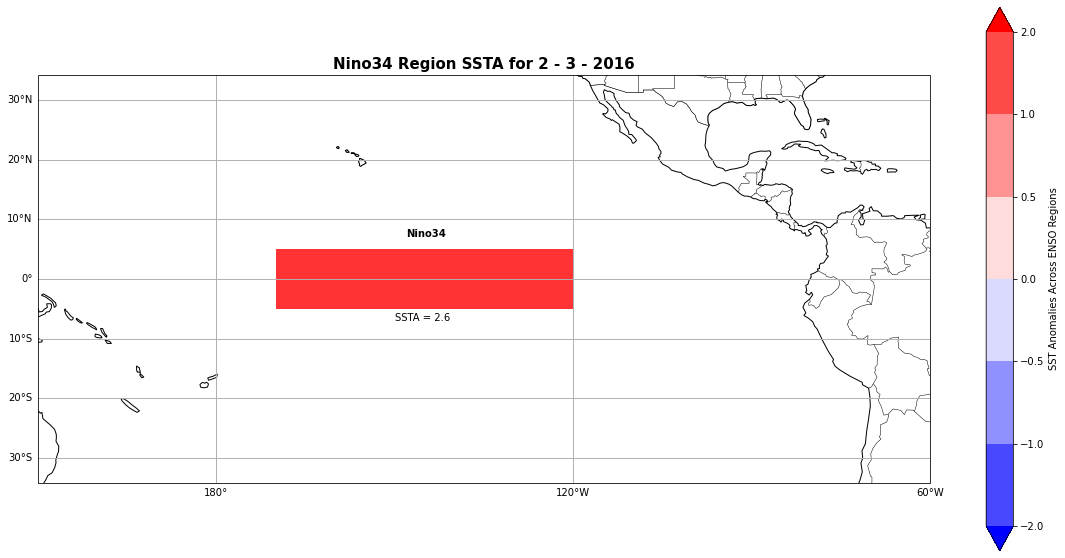

In [7]:
# Animated Plot

# This is similar to the plots above, but provides an animation to identify trends in ENSO over a user-specified
# period of time. This helps compliment the vertical bar chart seen in the previous time-series section

# User input for ENSO Region
ENSO_input = input("Enter ENSO Region (Nino1+2, Nino3, Nino34, Nino4)")
print("ENSO Region is: " + user_input_enso_var)

# User input for start/end dates for period of interest
start_year = input("Enter starting year of period:")
start_month = input("Enter starting month of period (need two digits for month):")
print("Starting period is: month= " + start_month + " year= " + start_year)

end_year = input("Enter ending year of period:")
end_month = input("Enter ending month of period (need two digits for month):")
print("Ending period is: month= " + end_month + " year= " + end_year)

# Isolates the data based on the date input that is used for animation
anim_df = enso_df["{}:SSTA".format(ENSO_input)].loc["{}""-""{}".format(start_year, start_month):"{}""-""{}".format(end_year, end_month)] 


# Function builds out specifications for mapping each region depending on user input
def enso_info(enso_region):
    if enso_region == 'Nino1+2':
        box_x = -90
        box_y = -10
        box_width = 10
        box_height= 10
        ssta_lat = -12
        ssta_lon = -88
        region_text_lat = 2
        region_text_lon = -90

    elif enso_region == 'Nino3':
        box_x = -150
        box_y = -5
        box_width = 60
        box_height= 10
        ssta_lat = -7
        ssta_lon = -125
        region_text_lat = 7
        region_text_lon = -125

    elif enso_region == 'Nino34':
        box_x = -170
        box_y = -5
        box_width = 50
        box_height= 10
        ssta_lat = -7
        ssta_lon = -150
        region_text_lat = 7
        region_text_lon = -148

    elif enso_region == 'Nino4':
        box_x = -200
        box_y = -5
        box_width = 30
        box_height= 10
        ssta_lat = -7
        ssta_lon = -190
        region_text_lat = 7
        region_text_lon = -188

    return(box_x, box_y, box_width, box_height, ssta_lat, ssta_lon, region_text_lat,region_text_lon)

enso_grab = enso_info(ENSO_input) # grab data using above function for selected region

# variable identification based on function output
box_x = enso_grab[0]
box_y = enso_grab[1]
box_width = enso_grab[2]
box_height = enso_grab[3]
ssta_lat = enso_grab[4]
ssta_lon = enso_grab[5]
region_text_lat = enso_grab[6]
region_text_lon =enso_grab[7]



####### Mapping Animation Script

# set cooler map

# identify plot and projection
fig,ax = plt.subplots(figsize=(20,10),subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=-75)))

ax.set_extent((150, 300, -10, 10)) # set map extent

# gridlines and other map features
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='black')
ax.coastlines()
ax.gridlines()

# mapping initializations
fill = ax.add_patch(mpatches.Rectangle(xy=[box_x, box_y], width= box_width, height= box_height, transform=ccrs.PlateCarree()))                              
text = ax.text(ssta_lon, ssta_lat,"SSTA:{}".format(anim_df[0]), transform=ccrs.PlateCarree())               
ax.set_title("Forecast Period = {}".format(anim_df[0]))  

# set colorbar parameters
cmap = mpl.cm.bwr
bounds = [-2, -1, -0.5, 0, 0.5, 1, 2]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both') 
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             orientation='vertical')
cbar.set_label("SST Anomalies Across ENSO Regions")

# label of ENSO region on map
ax.text(region_text_lon, region_text_lat, ENSO_input ,weight='bold', transform=ccrs.PlateCarree())

# set background patch for animation
fig.patch.set_facecolor('white')

# define function to animate maps for all selected ENSO periods
def animate(frame):
    global fill
    global text
    global gl
    fill.set_visible(False)
    text.set_visible(False)
    fill = ax.add_patch(mpatches.Rectangle(xy=[box_x, box_y], width= box_width, height= box_height,
                                    facecolor= '{}'.format(enso_color_code(anim_df[frame])[0]),
                                    alpha= float('{}'.format(enso_color_code(anim_df[frame])[1])),
                                    transform=ccrs.PlateCarree())
                  )       
    text = ax.text(ssta_lon, ssta_lat,"SSTA = {}".format(anim_df[frame]), transform=ccrs.PlateCarree())            
    ax.set_title('{} Region SSTA for {} - {} - {}'.format(ENSO_input, anim_df.index[frame].month, anim_df.index[frame].day, anim_df.index[frame].year), fontsize=15, weight='bold')

    
nframes = anim_df.index.size # get number of forecast periods - pass as number of frames into animation 

# Utilize animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=nframes,  # identify frames in animation
    interval=1000,    # ms between frames 
    blit=False
)

plt.draw()
plt.show()

HTML(ani.to_jshtml())


### Data Analytics - Relationships between point locations and ENSO indices ###

In [8]:
# Dictionary of cities - this includes lat/lon, city name and title for each location
# This is used to identify relationship between specific point locations and ENSO indices

cities = {
    'Boston': {
        'latitude': 42.090925,
        'longitude': -71.26435,
        'city_name' : 'Boston',
        'title': 'Boston, MA',
        
    },
    'Chicago': {
        'latitude': 41.862306,
        'longitude': -87.616672,
        'city_name' : 'Chicago',
        'title': 'Chicago, IL',
    },
    'New York': {
        'latitude': 40.812194,
        'longitude': -74.076983,
        'city_name' : 'New York',
        'title': 'New York, NY',
    },
    'Buffalo': {
        'latitude': 42.773739,
        'longitude': -78.786978,
        'city_name' : 'Buffalo',
        'title': 'Buffalo, NY',
    },
    'Pittsburg': {
        'latitude': 40.446786,
        'longitude': -80.015761,
        'city_name' : 'Pittsburg',
        'title': 'Pittsburg, PA',
    },
    'Philadelphia': {
        'latitude': 39.900775,
        'longitude': -75.167453,
        'city_name' : 'Philadelphia',
        'title': 'Philadelphia, PA',
    },
    'Cleveland': {
        'latitude': 41.506022,
        'longitude': -81.699564,
        'city_name' : 'Cleveland',
        'title': 'Cleveland, OH',
    },
    'Cincinnati': {
        'latitude': 39.095442,
        'longitude': -84.516039,
        'city_name' : 'Cincinnati',
        'title': 'Cincinnati, OH',
    },
    'Washington DC': {
        'latitude': 38.907697,
        'longitude': -76.864517,
        'city_name' : 'Washington DC',
        'title': 'Washington DC',
    },
    'Baltimore': {
        'latitude': 39.277969,
        'longitude':-76.622767,
        'city_name' : 'Baltimore',
        'title': 'Baltimore, MD',
    },
    'Nashville': {
        'latitude': 36.166461,
        'longitude':-86.771289,
        'city_name' : 'Nashville',
        'title': 'Nashville, TN',
    },
    'Charlotte': {
        'latitude': 35.225808,
        'longitude': -80.852861,
        'city_name' : 'Charlotte',
        'title': 'Charlotte, NC',
    },
    'Jacksonville': {
        'latitude': 30.323925,
        'longitude': -81.637356,
        'city_name' : 'Jacksonville',
        'title': 'Jacksonville, FL',
    },
    'Tampa Bay': {
        'latitude':27.975967,
        'longitude': -82.50335,
        'city_name' : 'Tampa Bay',
        'title': 'Tampa Bay, FL',
    },
    'Miami': {
        'latitude': 25.957919,
        'longitude': -80.238842,
        'city_name' : 'Miami',
        'title': 'Miami, FL',
    },
    'Green Bay': {
        'latitude': 44.501306,
        'longitude': -88.062167,
        'city_name' : 'Green Bay',
        'title': 'Green Bay, WI',
    },
    'Kansas City': {
        'latitude': 39.048914,
        'longitude': -94.484039,
        'city_name' : 'Kansas City',
        'title': 'Kansas City, MO',
    },
    'Denver': {
        'latitude': 39.743936,
        'longitude': -105.020097,
        'city_name' : 'Denver',
        'title': 'Denver, CO',
    },
    'Seattle': {
        'latitude': 47.595153,
        'longitude': -122.331625,
        'city_name' : 'Seattle',
        'title': 'Seattle, WA',
    },
    'San Francisco': {
        'latitude': 37.713486,
        'longitude':-122.386256,
        'city_name' : 'San Francisco',
        'title': 'San Francisco, CA',
    },
    'Des Moines': {
        'latitude': 41.5868,
        'longitude':-93.6250,
        'city_name' : 'Des Moines',
        'title': 'Des Moines, IA',
    },
    'Minneapolis': {
        'latitude': 44.9778,
        'longitude':-93.2650,
        'city_name' : 'Minneapolis',
        'title': 'Minneapolis, MN',
    },  
    
}

            Nino1+2:SSTA  Nino3:SSTA  Nino34:SSTA  Nino4:SSTA
Date                                                         
1981-09-01        -0.560      -0.300       -0.300      -0.380
1981-10-01        -0.700      -0.225       -0.250      -0.250
1981-11-01        -0.475      -0.575       -0.675      -0.400
1981-12-01        -0.060      -0.180       -0.360      -0.280
1982-01-01        -0.300       0.175        0.100      -0.200
...                  ...         ...          ...         ...
2022-10-01        -1.700      -0.925       -0.850      -1.125
2022-11-01        -1.340      -0.920       -0.940      -0.920
2022-12-01        -0.300      -0.775       -0.850      -0.750
2023-01-01        -0.375      -0.500       -0.675      -0.625
2023-02-01         0.500      -0.175       -0.450      -0.550

[498 rows x 4 columns]
The stations for the locations included:                                                     name country region  \
id                                                    

<AxesSubplot:>

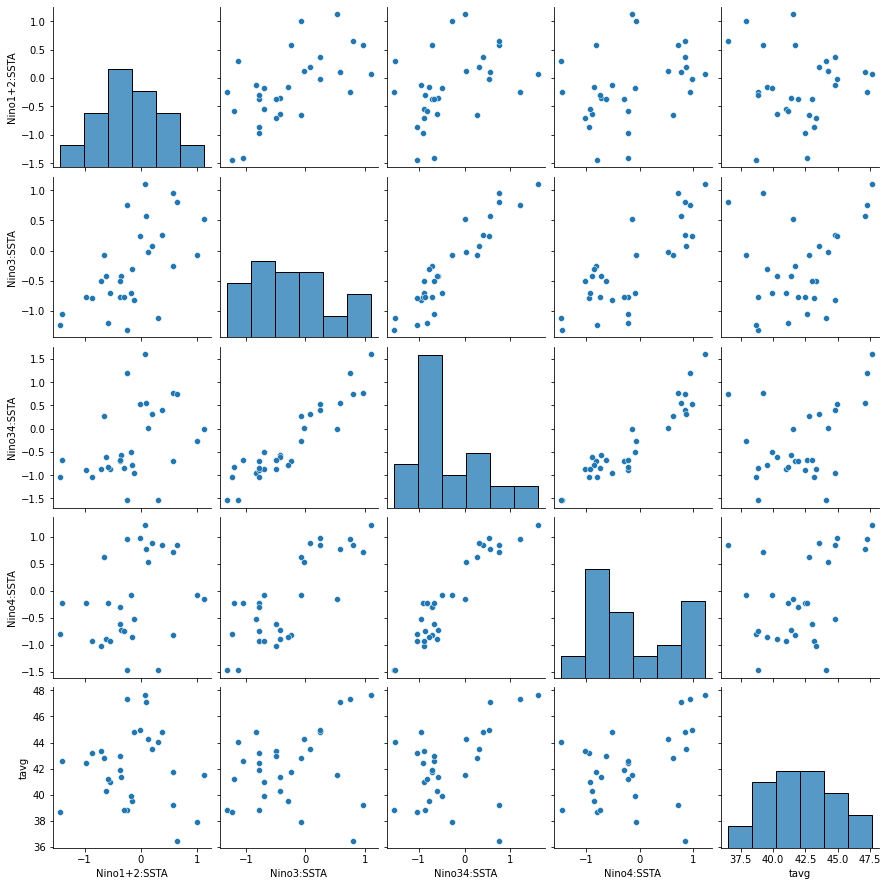

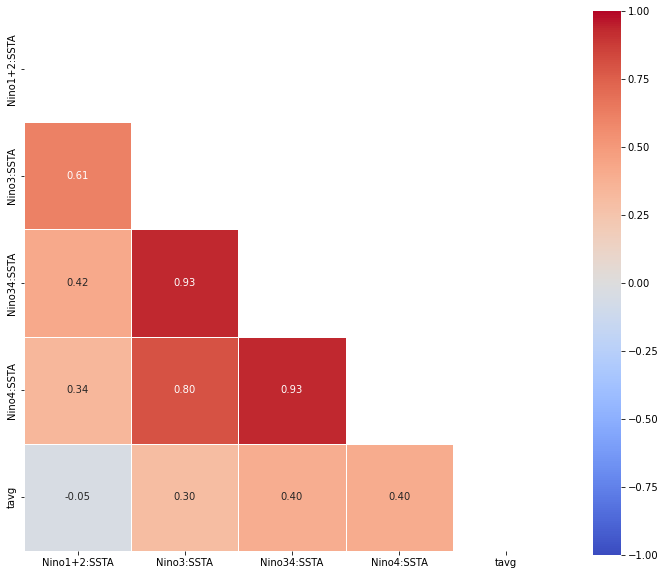

In [11]:
# This script will download point location data over a city/location for a specific season based on user input. 
# Meteostat network of observational data will be used to download weather data (temperature) over that location and
# merge that dataset with the ENSO indices. This will then be correlated to determine if there is a relationship between
# the observational data for that location and each of the ENSO indices

# Location input
user_input_loc = input("Enter city/location (this can be choosen based on the options above):")

# Select season for correlation
season_sel = input("Enter season (winter, spring, summer, fall):")

# Set weather parameter to temperature
climo_indice = 'tavg'

# Make a copy of the original dataset
monthly_enso = enso_df

# Create new 'Date' column
monthly_enso['Date'] = monthly_enso.index 

# Set Date column to datetime
monthly_enso.Date = pd.to_datetime(enso_df.index)

# Resample data to monthly using average values
monthly_resample = monthly_enso.resample('MS', on = 'Date').mean()

print(monthly_resample)

# full climo for station location extending 1981-2022
# This will need to be customized based on availablility of station location data

# Set time period
start = datetime(1981, 9, 1)
end = datetime(2023, 2, 1)

# nearby stations are aggregated 
stations = Stations()
stations = stations.nearby(cities[user_input_loc]['latitude'],cities[user_input_loc]['longitude'])

# 10 of the closest observation stations are used to determine which station best meets date criteria. 
station = stations.fetch(10)
print("The stations for the locations included:", station)
for a in range(0,10,1):   
        if (station['monthly_start'].dt.year.values[a] <= 1981) & (station['monthly_end'].dt.year.values[a] >= 2022):
            print("this station works")
            station_climo = station.loc[(station.index== station.index[a])]
            break

station = station_climo.index.values[0]
print(station)

# Get monthly data
data_monthly_climo = Monthly(station, start, end)
data_monthly_climo = data_monthly_climo.fetch()

# index is set to "Date" so data can be merged to existing teleconnection DF
data_monthly_climo.index.names = ['Date']

if climo_indice == 'tavg':
    data_monthly_climo.tavg = (data_monthly_climo .tavg * 9/5) + 32


# Relavent weather data is extracted
var_monthly_climo = data_monthly_climo[climo_indice]


# Meteostat station data is merged to ENSO DF 
newdf_climo = pd.merge(monthly_resample,data_monthly_climo[climo_indice], how= 'outer',on='Date')


# procedure to clean dataset of nans - this is completed for all columns

# drop nan values over all columns
newdf_climo_imp = newdf_climo.dropna()

# confirm all nan values have been removed
print(newdf_climo_imp.isna().sum())


# Aggreate data only for the specified season
if season_sel == 'winter':
    season_data = newdf_climo_imp.loc[(newdf_climo_imp.index.month.values == 12) |
                                        (newdf_climo_imp.index.month.values == 1) |
                                        (newdf_climo_imp.index.month.values == 2)]
if season_sel == 'spring':
    season_data = newdf_climo_imp.loc[(newdf_climo_imp.index.month.values == 3) |
                                        (newdf_climo_imp.index.month.values == 4) |
                                        (newdf_climo_imp.index.month.values == 5)]
if season_sel == 'summer':
    season_data = newdf_climo_imp.loc[(newdf_climo_imp.index.month.values == 6) |
                                        (newdf_climo_imp.index.month.values == 7) |
                                        (newdf_climo_imp.index.month.values == 8)]
if season_sel == 'fall':
    season_data = newdf_climo_imp.loc[(newdf_climo_imp.index.month.values == 9) |
                                        (newdf_climo_imp.index.month.values == 10) |
                                        (newdf_climo_imp.index.month.values == 11)]

full_merged_data = newdf_climo_imp
newdf_climo_imp = season_data


print(newdf_climo_imp)

# Pairplot using seaborn
sns.pairplot(newdf_climo_imp)


# Correlation heat map

# correlate values in dataset
newdf_climo_corr = newdf_climo_imp.corr() 

# mask out upper triangle of values                                             
mask = np.triu(np.ones_like(newdf_climo_corr, dtype=bool))

# initiate subplot
fig, ax = plt.subplots(figsize=(12, 10))

cmap = 'coolwarm' # color map to identify +/- correlations

# create heatmap of correlation values                                 
sns.heatmap(newdf_climo_corr, mask=mask,annot=True, fmt=".2f", # two digits after decimal point
          cmap=cmap, vmin=-1, vmax=1, # (3) 
           square=True,linewidth=1)  # (4)


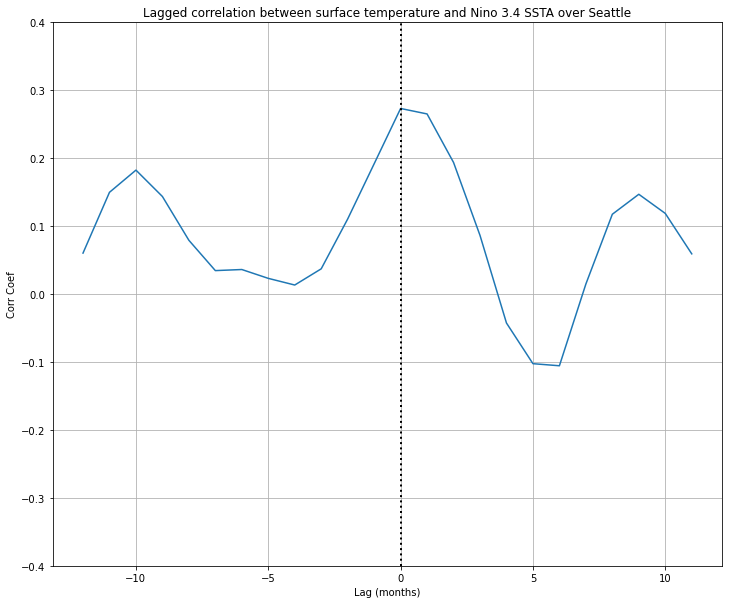

In [12]:
# Cross-correlation plot showing lagged correlation between the ENSO index and monthly averaged temperature
# lag period spans -12 to +12 months from observation

# calculate the correlation between temperatue and index at different lags
lags = range(-12, 12)  # lags from -12 to 12 month
corr = [full_merged_data['tavg'].corr(full_merged_data['Nino34:SSTA'].shift(lag)) for lag in lags]

# plot the lagged correlation
plt.subplots(figsize=(12, 10))
plt.plot(lags, corr)
plt.title('Lagged correlation between surface temperature and Nino 3.4 SSTA over {}'.format(user_input_loc))
plt.xlabel('Lag (months)')
plt.axvline(x = 0, color = 'k', ls=':', lw=2)

plt.ylabel('Corr Coef')
plt.ylim([-0.4, 0.4])
plt.grid()
plt.show()
